In [4]:
#files
import sys
from os import listdir
sys.path.append('../data')
sys.path.append('../Librerias')
from os.path import isfile, join

#own libs
import utils
import caract as dc
import dataset as ds


#data and visualization
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go

sns.set_style("darkgrid")


# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
 


In [5]:
#fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/high/"
fpath =  "/Users/consu/OneDrive/Documentos/GitHub/Tesis/data/low/"
onlyfiles = [f for f in listdir(fpath) if isfile(join(fpath, f))]

cutoff = [8/1000, 11/1000]

#load data
frames = []
for fname in onlyfiles:
    if fname.endswith(".mat"):
        set =  ds.MatFileToDataFrame(fpath, fname)
        df = set.get_dataframe(cutoff)
        frames.append(df)
        print(fname)

frames = frames[:2]

defectos_frames = []
taus = []
for i, df in enumerate(frames):
    aux = dc.CaractDefect(df)
    defectos_frames.append(aux)
    taus.append(aux.get_tau()[1])
    sys.stdout.write(str(i) + '\r')


hilbert_frames = []
for i, df in enumerate(defectos_frames):
    aux, _ = df.get_hilbert()
    hilbert_frames.append(aux)
    sys.stdout.write(str(i) + '\r')


frames_all = []

for i in range(len(frames)):
    frames_all.append(pd.merge(frames[i], hilbert_frames[i], on='Hilbert Transform', how='outer'))

frames_all[0]

file10_080124.mat
file11_080124.mat
file12_080124.mat
file13_080124.mat
file15_080124.mat
file16_080124.mat
file17_080124.mat
file18_080124.mat
file1_050124.mat
file1_080124.mat
file2_050124.mat
file3_080124.mat
file7_080124.mat
file8_080124.mat
file9_080124.mat
low1_100124.mat
low2_100124.mat
low3_100124.mat
low5_100124.mat


,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude,Instantaneous Phase,Gradient Phase
0,0.076967,-0.041045,-0.005045,-0.005045+0.003866j,0.006356,2.487745,-0.050221
1,0.076638,-0.041374,-0.004841,-0.004841+0.000279j,0.004849,3.083952,-0.023636
2,0.073022,-0.044991,-0.004633,-0.004633+0.000083j,0.004634,3.123610,0.001438
3,0.073022,-0.044991,-0.004421,-0.004421-0.001203j,0.004582,3.407171,0.023619
4,0.071378,-0.046635,-0.004205,-0.004205-0.001356j,0.004419,3.453607,0.041826
...,...,...,...,...,...,...,...
599995,0.176268,0.058256,0.000015,0.000015+0.000493j,0.000493,30135.697377,-0.289769
599996,0.177254,0.059242,0.000033,0.000033+0.000343j,0.000345,30135.630801,-0.245612
599997,0.179227,0.061215,0.000050,0.000050+0.001284j,0.001285,30135.688260,-0.187389
599998,0.179885,0.061872,0.000066,0.000066+0.001095j,0.001097,30135.667052,-0.118399


In [39]:
df = frames_all[0]
def split_dataset(data):
    train, test = data['Amplitude'][:10000], data['Amplitude'][10000:20000]
    train = array(split(train, len(train)/50))
    test = array(split(test, len(test)/50))
    return np.expand_dims(train, 2), np.expand_dims(test, 2)

In [41]:
x, y = split_dataset(df)
x.shape, y.shape

((200, 50, 1), (200, 50, 1))

In [42]:
def evaluate_forecast(actual, predicted):
    scores = list() #for each prediction

    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        score.append(rmse)

    S = 0 #overall rmse
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            S += (actual[row, col] - predicted[row, col])**2
    score = sqrt(S/(actual.shape[0]*actual.shape[1]))

    return score, scores

In [43]:
def to_supervise(train, n_inputs, n_outputs = 10):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0

    for _ in range(len(data)):
        in_end = in_start + n_inputs
        out_end = in_end + n_outputs

        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        in_start += 1

    return array(X), array(y)

In [50]:
def build_model(train, n_input):
    train_x, train_y = to_supervise(train, n_input)
    verbose, epochs, batch_size = 1, 10, 32
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

    #define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    #fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

In [54]:
def forecast(model, history, n_input):
    #flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    #retrieve last observations
    input_x = data[-n_input:, :0]
    #reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    #forecast the next 50
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

def evaluate_model(train, test, n_input):
    model = build_model(train, n_input)
    history = [x for x in train]
    predictions = list()

    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])

    predictions = array(predictions)
    #score, scores = evaluate_forecast(test[:, :, 0], predictions)
    return model, predictions

In [55]:
train, test = split_dataset(df)
n_input = 100
model, predictions = evaluate_model(train, test, n_input)


Epoch 1/10
308/308 [==============================] - 54s 167ms/step - loss: 2.9434e-07
Epoch 2/10
308/308 [==============================] - 51s 166ms/step - loss: 1.9541e-07
Epoch 3/10
308/308 [==============================] - 52s 168ms/step - loss: 1.9410e-07
Epoch 4/10
308/308 [==============================] - 57s 184ms/step - loss: 2.0938e-07
Epoch 5/10
308/308 [==============================] - 51s 166ms/step - loss: 2.2397e-07
Epoch 6/10
308/308 [==============================] - 50s 162ms/step - loss: 1.9981e-07
Epoch 7/10
308/308 [==============================] - 53s 171ms/step - loss: 1.8182e-07
Epoch 8/10
308/308 [==============================] - 55s 178ms/step - loss: 1.8462e-07
Epoch 9/10
308/308 [==============================] - 57s 184ms/step - loss: 1.7526e-07
Epoch 10/10
308/308 [==============================] - 55s 178ms/step - loss: 1.9137e-07


ValueError: in user code:

    File "c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\consu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_6' (type Sequential).
    
    Input 0 of layer "lstm_12" is incompatible with the layer: expected shape=(None, None, 1), found shape=(None, 100, 0)
    
    Call arguments received by layer 'sequential_6' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 100, 0), dtype=float32)
      • training=False
      • mask=None


### **este funciona perooo**

hay una cosa rara en los test de predicción, hay que ver si la predicción y el actual sean de la misma dimensión y hay que arreglar ese problema porque tecnicamente esta malo.

lstm: [0.001] 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0


ValueError: x and y must have same first dimension, but have shapes (7,) and (10,)

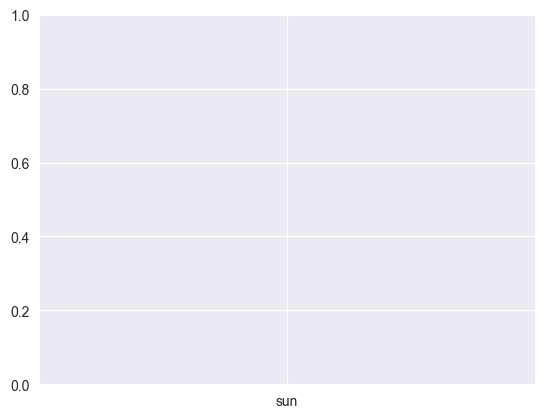

In [79]:
# univariate multi-step encoder-decoder lstm
from math import sqrt
from numpy import split, array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed

# split a univariate dataset into train/test sets
def split_dataset(data):
    train_size = 10000
    train, test = data[:train_size], data[train_size:train_size+50]  # Adjusted for a forecast horizon of 50 steps
    train = array(split(train, len(train) // 10))
    test = array(split(test, len(test) // 10))
    return train, test

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = [sqrt(mean_squared_error(actual[:, i], predicted[:, i])) for i in range(actual.shape[1])]
    score = sqrt(((actual - predicted) ** 2).mean())
    return score, scores

# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    data = train.reshape((train.shape[0] * train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):
        in_end, out_end = in_start + n_input, in_start + n_input + n_out
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    train_x, train_y = to_supervised(train, n_input, 50)  # Adjusted for a forecast horizon of 50 steps
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    data = array(history)
    data = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
    input_x = data[-n_input:, 0]
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    model = build_model(train, n_input)
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        yhat_sequence = forecast(model, history, n_input)
        predictions.append(yhat_sequence)
        history.append(test[i, :])
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions[:,:10].squeeze())
    return model, predictions, score, scores

# load the new file
#dataset = read_csv('your_dataframe.csv')  # Replace 'your_dataframe.csv' with your actual file path
data = df['Amplitude'].values.reshape(-1, 1)  # Assuming 'Amplitude' is the column name
# include 10,000 points for training
train_data = data[:10000].reshape(-1, 1)
# split into train and test
train, test = split_dataset(data)
# evaluate model and get scores
n_input = 14
score, scores = evaluate_model(train, test, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
#days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
#pyplot.plot(days, scores, marker='o', label='lstm')
#pyplot.show()


In [81]:
scores

[0.0009360343632841807,
 0.0009199207585673672,
 0.0009037461661097017,
 0.000887293137228597,
 0.0008707818636225401,
 0.0008540289187968372,
 0.0008372218280725868,
 0.0008202113321730752,
 0.0008031524218066071,
 0.0007859299002905969]